<a href="https://colab.research.google.com/github/kevmansilla/redes-neuronales-trabajos/blob/main/Hh_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# 1.b)
# https://stackoverflow.com/questions/48905127/importing-py-files-in-google-colab
#import ode

def euler(f,x,t,h,p):
    """
    Calcula un paso de integración del método de Euler.

    Argumentos de entrada:

        f : R^n,R -> R^n
        x = x(t) : R^n
        t = tiempo : R
        h = paso de tiempo : R
        p = parametros : R^q

    Retorna aproximacion numérica de

        x(t+h) : R^n

    según el método de Euler.

    # Ejemplos:
    """
    return x+h*f(x,t,p)

def rk4(f,x,t,h,p):
    """
    Calcula un paso de integración del método de Runge Kutta orden 4.

    Argumentos de entrada:

        f : R^n -> R^n
        x = x(t) : R^n
        t = tiempo : R
        h = paso de tiempo : R
        p = parametros : R^q

    Retorna aproximacion numérica de

        x(t+h) : R^n

    según el método de Runge-Kutta de orden 4.

    # Ejemplos:
    """
    k1 = f(x,t,p)
    k2 = f(x+0.5*h*k1,t+0.5*h,p)
    k3 = f(x+0.5*h*k2,t+0.5*h,p)
    k4 = f(x+h*k3,t+h,p)
    return x+h*(k1+2.0*k2+2.0*k3+k4)/6.0

def integrador_ode(m,f,xa,a,b,k,p,c=lambda x,t,p:x):
    """
    Integra numéricamente la ODE

        dx/dt = f(x,t)

    sobre el intervalo t:[a,b] usando k pasos de integración y el método m, bajo condicion inicial x(a)=x0.
    No es necesario que a<b.

    Argumentos de entrada:

        m = metodo de integracion (ej. euler, rk2, etc.)
        f : R^n -> R^n
        xa = condicion inicial : R
        a = tiempo inicial : R
        b = tiempo final : R
        k = num. pasos de integracion : N
        p = parametros : R^q
        c = función condicionante : R^n,R,p -> R^n

    Retorna:

        t : R^{k+1} , t_j = a+j*h para j=0,1,...,k
        w : R^{n,k+1} , w_ij = x_i(t_j) para i=0,1,...,n-1 y j=0,1,...,k

    donde a+k*dt = b.
    """
    assert k>0
    n = len(xa)
    h = (b-a)/k
    w = np.zeros((n,k+1)) # Produce un array con forma y tipo especificada con los parametros,
                          # lleno de ceros. la forma puede ser espcificada con un entero o tupla (n,k+1)
    t = np.zeros(k+1)
    w[:,0] = xa           # actualiza la posicion inicial (columna de indice 0) de las variables con los valores
                          # de las condiciones iniciales
    t[0] = a              # actualiza la posicion cero con el valor del tiempo inicial

    for j in range(k):    #Aca se produce la iteración en j

        t[j+1] = t[j] + h                # iteracion tiempo
        w[:,j+1] = m(f,w[:,j],t[j],h,p)  # iteracion de w
        w[:,j+1] = c(w[:,j+1],t[j+1],p)  # condicion sobre w

    return t,w

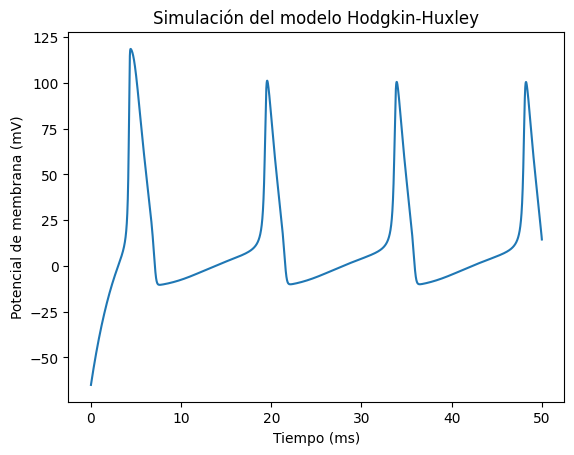

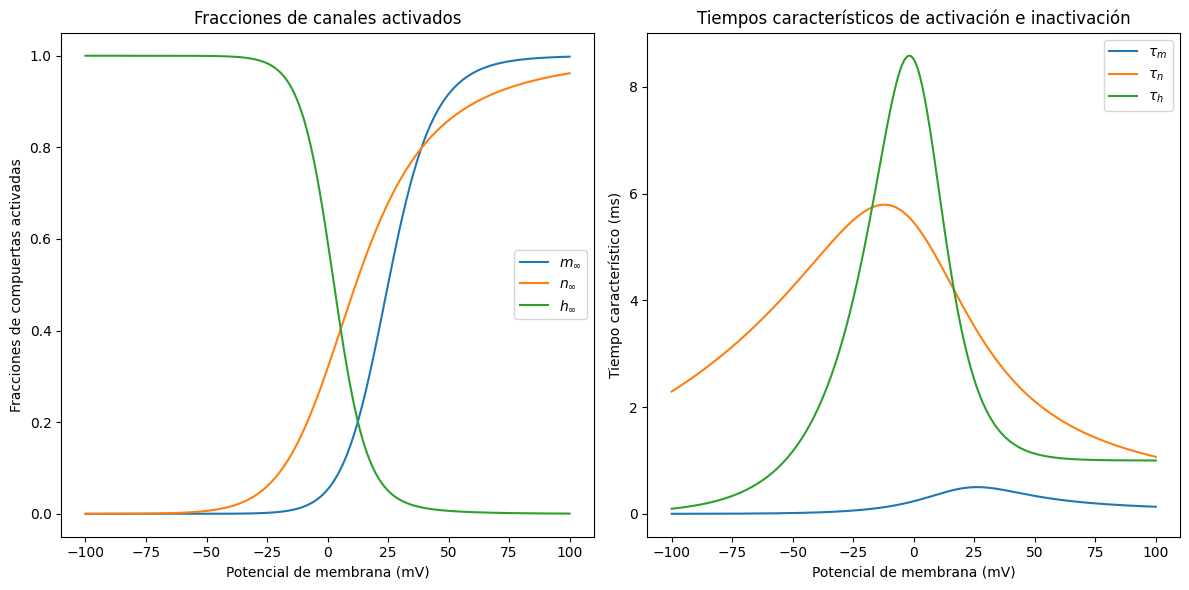

In [ ]:


# Constantes del modelo de Hodgkin-Huxley
C_m = 1.0  # Capacitancia de la membrana
g_Na = 120.0  # Conductancia de sodio (Na)
g_K = 36.0  # Conductancia de potasio (K)
g_L = 0.3  # Conductancia de perdida
E_Na = 120.0  # Potencial de reversion de sodio
E_K = -12.0  # Potencial de reversion de potasio
E_L = 10.6  # Potencial de reversion de perdida

# Funciones de corriente
def I_Na(V, m, h):
    return g_Na * m**3 * h * (V - E_Na)

def I_K(V, n):
    return g_K * n**4 * (V - E_K)

def I_L(V):
    return g_L * (V - E_L)

# Funciones para actualizar m, h, n
def alpha_m(V):
    return 0.1 * (25 - V) / (np.exp((25 - V) / 10) - 1)

def beta_m(V):
    return 4.0 * np.exp(-V / 18)

def alpha_h(V):
    return 0.07 * np.exp(-V / 20)

def beta_h(V):
    return 1.0 / (np.exp((30 - V) / 10) + 1)

def alpha_n(V):
    return 0.01 * (10 - V) / (np.exp((10 - V) / 10) - 1)

def beta_n(V):
    return 0.125 * np.exp(-V / 80)

# Función de equilibrio para m, n, h
def m_inf(V):
    return alpha_m(V) / (alpha_m(V) + beta_m(V))

def h_inf(V):
    return alpha_h(V) / (alpha_h(V) + beta_h(V))

def n_inf(V):
    return alpha_n(V) / (alpha_n(V) + beta_n(V))

# Tiempos característicos
def tau_m(V):
    return 1 / (alpha_m(V) + beta_m(V))

def tau_h(V):
    return 1 / (alpha_h(V) + beta_h(V))

def tau_n(V):
    return 1 / (alpha_n(V) + beta_n(V))

# Función f(x,t,p) para el integrador (x = [V, m, h, n])
def hh_model(x, t, p):
    V, m, h, n = x  # Variables
    I_ext = p  # Corriente externa

    # Corrientes
    INa = I_Na(V, m, h)
    IK = I_K(V, n)
    IL = I_L(V)

    # Derivadas
    dVdt = (I_ext - (INa + IK + IL)) / C_m
    dmdt = alpha_m(V) * (1 - m) - beta_m(V) * m
    dhdt = alpha_h(V) * (1 - h) - beta_h(V) * h
    dndt = alpha_n(V) * (1 - n) - beta_n(V) * n

    return np.array([dVdt, dmdt, dhdt, dndt])

# Condiciones iniciales
V0 = -65  # Potencial inicial
m0, h0, n0 = m_inf(V0), h_inf(V0), n_inf(V0)  # Variables iniciales de las compuertas en equilibrio
x0 = np.array([V0, m0, h0, n0])

# Parámetros de la simulación
T = 50  # Tiempo total de simulación (ms)
dt = 0.005  # Paso de tiempo (ms)
I_ext = 10  # Corriente externa aplicada (

# Integrador
t, w = integrador_ode(rk4, hh_model, x0, 0, T, int(T/dt), I_ext)

# Grafico potencial de membrana
plt.plot(t, w[0, :])  # Potencial de membrana V(t)
plt.xlabel('Tiempo (ms)')
plt.ylabel('Potencial de membrana (mV)')
plt.title('Simulación del modelo Hodgkin-Huxley')
plt.show()

# Gráfico fracciones de compuertas activadas
V_vals = np.linspace(-100, 100, 400)  # Valores de potencial de membrana

plt.figure(figsize=(12, 6))

# Gráfico de m_inf, n_inf, h_inf
plt.subplot(1, 2, 1)
plt.plot(V_vals, m_inf(V_vals), label='$m_\\infty$')
plt.plot(V_vals, n_inf(V_vals), label='$n_\\infty$')
plt.plot(V_vals, h_inf(V_vals), label='$h_\\infty$')
plt.xlabel('Potencial de membrana (mV)')
plt.ylabel('Fracciones de compuertas activadas')
plt.legend()
plt.title('Fracciones de canales activados')

# Gráfico de tau_m, tau_n, tau_h
plt.subplot(1, 2, 2)
plt.plot(V_vals, tau_m(V_vals), label='$\\tau_m$')
plt.plot(V_vals, tau_n(V_vals), label='$\\tau_n$')
plt.plot(V_vals, tau_h(V_vals), label='$\\tau_h$')
plt.xlabel('Potencial de membrana (mV)')
plt.ylabel('Tiempo característico (ms)')
plt.legend()
plt.title('Tiempos característicos de activación e inactivación')

plt.tight_layout()
plt.show()